# Clustering: Bisecting K-means

## References

https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data?select=Country-data.csv

## Import Python Libraries

In [442]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.utils import resample

## Global Variables

In [443]:
# random state 
random_state = 4781
# random_state = 7644

# colors
c_scale = 256
c1 = (1, 1, 1) # grey
c2 = (1, 0, 0) # red
c3 = (181/c_scale, 204/c_scale, 6/c_scale) # yellow
c4 = (6/c_scale, 122/c_scale, 204/c_scale) # blue
c5 = (0, 0, 0) # black
c6 = ["#fbfce6", "#a2daf2", "#ffc7c7", '#8e6a9e']
c7 = [(0, 0, 1), (0, 1 ,0), (1, 0, 0), (1, 1, 0)]

## Import Dataset

In [444]:
# Source: https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data?select=Country-data.csv

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

#  y: country	Name of the country
# X1: child_mort	Death of children under 5 years of age per 1000 live births
# X2: exports	Exports of goods and services per capita. Given as %age of the GDP per capita
# X3: health	Total health spending per capita. Given as %age of GDP per capita
# X4: imports	Imports of goods and services per capita. Given as %age of the GDP per capita
# X5: Income	Net income per person
# X6: Inflation	The measurement of the annual growth rate of the Total GDP
# X7: life_expec	The average number of years a new born child would live if the current mortality patterns are to remain the same
# X8: total_fer	The number of children that would be born to each woman if the current age-fertility rates remain the same.
# X9: gdpp	The GDP per capita. Calculated as the Total GDP divided by the total population.

In [445]:
# load dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/country_data.csv'
df0 = pd.read_csv(filepath1, header = 0)
df0.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [446]:
# identify X_cols and y_col
all_cols = df0.columns.values.copy()
y_col = 'country'
cond1 = all_cols != y_col
X_cols = all_cols[cond1]

In [447]:
# standardize column names
df1 = df0.copy()
zeros = len(str(len(X_cols)))
new_all_cols = all_cols
temp = (np.arange(0, len(X_cols)) + 1).astype('str')

new_y_col = 'y'
new_X_cols = ['X' + i.zfill(zeros) for i in temp]

new_all_cols[cond1] = new_X_cols
new_all_cols[~cond1] = new_y_col

df1.columns = new_all_cols

df1.y = df1.y.astype('str')

df1.head()


,y,X1,X2,X3,X4,X5,X6,X7,X8,X9
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [448]:
# check data structure
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       167 non-null    object 
 1   X1      167 non-null    float64
 2   X2      167 non-null    float64
 3   X3      167 non-null    float64
 4   X4      167 non-null    float64
 5   X5      167 non-null    int64  
 6   X6      167 non-null    float64
 7   X7      167 non-null    float64
 8   X8      167 non-null    float64
 9   X9      167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [449]:
# describe data
df1.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [450]:
# check missing values
df1.isna().sum()

y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
X9    0
dtype: int64

## Data Cleaning and Transformation

In [451]:
# response column
y_col = new_y_col
y_col

'y'

In [452]:
# predictor columns
cond1 = df1.columns != y_col
X_cols = df1.columns[cond1]
X_cols

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9'], dtype='object')

In [453]:
# get unique y_labels
y_labels = np.sort(df1[y_col].unique())
y_labels = {y_labels[i]: i for i in range(len(y_labels))}
# y_labels = {i:y_labels[i] for i in range(len(y_labels))}
y_labels

{'Afghanistan': 0,
 'Albania': 1,
 'Algeria': 2,
 'Angola': 3,
 'Antigua and Barbuda': 4,
 'Argentina': 5,
 'Armenia': 6,
 'Australia': 7,
 'Austria': 8,
 'Azerbaijan': 9,
 'Bahamas': 10,
 'Bahrain': 11,
 'Bangladesh': 12,
 'Barbados': 13,
 'Belarus': 14,
 'Belgium': 15,
 'Belize': 16,
 'Benin': 17,
 'Bhutan': 18,
 'Bolivia': 19,
 'Bosnia and Herzegovina': 20,
 'Botswana': 21,
 'Brazil': 22,
 'Brunei': 23,
 'Bulgaria': 24,
 'Burkina Faso': 25,
 'Burundi': 26,
 'Cambodia': 27,
 'Cameroon': 28,
 'Canada': 29,
 'Cape Verde': 30,
 'Central African Republic': 31,
 'Chad': 32,
 'Chile': 33,
 'China': 34,
 'Colombia': 35,
 'Comoros': 36,
 'Congo, Dem. Rep.': 37,
 'Congo, Rep.': 38,
 'Costa Rica': 39,
 "Cote d'Ivoire": 40,
 'Croatia': 41,
 'Cyprus': 42,
 'Czech Republic': 43,
 'Denmark': 44,
 'Dominican Republic': 45,
 'Ecuador': 46,
 'Egypt': 47,
 'El Salvador': 48,
 'Equatorial Guinea': 49,
 'Eritrea': 50,
 'Estonia': 51,
 'Fiji': 52,
 'Finland': 53,
 'France': 54,
 'Gabon': 55,
 'Gambia': 5

In [454]:
# rename y_labels
df1[y_col] = df1[y_col].replace(y_labels)
df1.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9
0,0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [455]:
# # check label distribution
# temp_labels = list(y_labels.values())
# cond_list = []
# count_list = []
# for i in np.arange(len(temp_labels)):
#   # condition for rows matching response label
#   # print(i)
#   x = temp_labels[i]
#   temp_cond = list(df1[y_col] == x)
#   cond_list.append(temp_cond)
#   # print(cond_list)
#   # get total label count
#   temp_n = np.sum(cond_list[i])
#   # print(temp_n)
#   count_list.append(temp_n)
  
# # max label count
# n_max = np.max(count_list)
# # index where max value occurs
# i_max = np.where(count_list == n_max)[0][0]
# # index where max value does not occurs
# i_notmax = np.where(count_list != n_max)[0]

# print(temp_labels)
# print(count_list)
# print(n_max)
# print(i_max)
# print(i_notmax)

In [456]:
# # upsample minority labels
# df_upsample_list = []
# for i in i_notmax:
#   # print(i)
#   # get dataframe rows where label exsists
#   cond = cond_list[i]
#   # print(cond)
#   df_temp = df1.iloc[cond,:]
#   # print(df_temp.info())
  
#   # determine amount to upsample 
#   n_diff = n_max - count_list[i]
#   # print(n_diff)
  
#   # generate upsample dataframe 
#   df_upsample_temp = resample(
#     df_temp,
#     replace = True,
#     n_samples = n_diff,
#     random_state = random_state
#   )
#   df_upsample_list.append(df_upsample_temp)

# # put all dataframes in df_upsample_list into one
# df_upsample_list = pd.concat(df_upsample_list, ignore_index = True)

# # update df1 with upsampled dataframe
# df1 = pd.concat([df1, df_upsample_list], ignore_index = True)
# df1.info()

In [457]:
# # encode categorical values to numerical values
# le = LabelEncoder()

# categorical_cols = df1[X_cols].select_dtypes("object").columns
# # df1[categorical_cols] = df1[categorical_cols].apply(le.fit_transform)

# df1.head()

In [458]:
# # transform specific columns
# for X in df1.columns:
#   a = np.abs(df1[X].min()) + 1 + df1[X]
#   df1[X] = np.log(a)
  
#   df1[X]

In [459]:
# update df1
X = df1[X_cols]
y = df1[y_col]
df1 = pd.concat([X, y], axis = 1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      167 non-null    float64
 1   X2      167 non-null    float64
 2   X3      167 non-null    float64
 3   X4      167 non-null    float64
 4   X5      167 non-null    int64  
 5   X6      167 non-null    float64
 6   X7      167 non-null    float64
 7   X8      167 non-null    float64
 8   X9      167 non-null    int64  
 9   y       167 non-null    int64  
dtypes: float64(7), int64(3)
memory usage: 13.2 KB


In [460]:
# normalize all X_cols
df2 = df1.copy()
norm = StandardScaler()
# norm = MinMaxScaler()
# norm = RobustScaler()
df2[X_cols] = norm.fit_transform(df2[X_cols])

df2.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,y
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180,0
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623,1
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376,2
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268,3
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817,4


In [461]:
# # remove outliers from each column
# for X in X_cols:
#   cond1 = ~((df2[X] >= 3) | (df2[X] <= -3))
#   df2 = df2.loc[cond1,:]
  
# df2.info()

## Visualize Dataset

In [462]:
# figure setup
fig_cols = 3
fig_rows = np.ceil(len(X_cols)/fig_cols).astype('int')
y_max = np.round(df2[X_cols].max().max(), 0)
y_min = np.round(df2[X_cols].min().min(), 0)
n_levels = df2.y.unique().size
palette1 = [c1 for i in range(n_levels)]
palette2 = [c3, c4]
figsize = (15, 15)

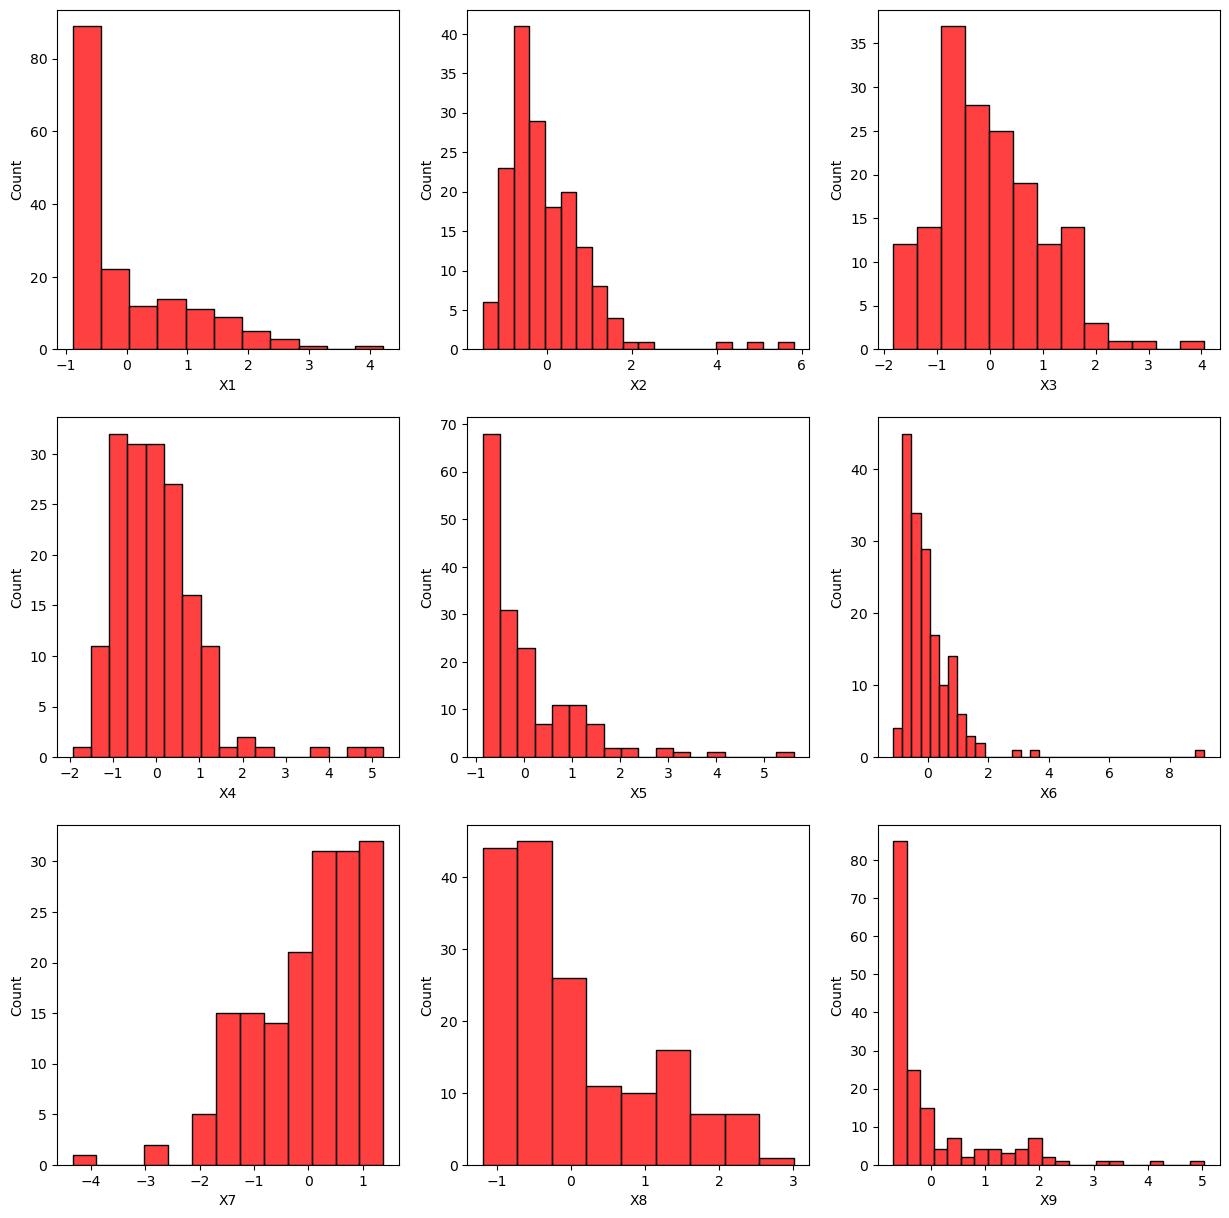

In [463]:
# subplot of y vs each X (stripplot + violinplot + boxenplot)
f1, axes = plt.subplots(fig_rows, fig_cols, figsize = figsize)
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  # p1 = sns.violinplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  # p2 = sns.boxenplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  # p3 = sns.scatterplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c2, size = 1)
  # p4 = sns.pointplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c5, linewidth = 1)
  p5 = sns.histplot(ax = axes[row, col], data = df2, x = x, color = c2, linewidth = 1)
  axes[row, col].legend_ = None
  # axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

## Train and Test ML Model

In [464]:
# seperate data into X and y
X = df2[X_cols]
y = np.ravel(df2[y_col])

In [465]:
# split data into train and test datasets
X_train, X_test = train_test_split(X,
  train_size = 0.8, random_state = random_state
)

In [466]:
# get principal components
pca = PCA(n_components = 2)

In [467]:
# fit principal components to training data
temp = pca.fit(X_train)

In [468]:
# pca explained variance ration
var_ratio = pca.explained_variance_ratio_
var_ratio.sum()

0.6614369226240839

In [469]:
# transform data based on principal components
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X = pca.transform(X)

In [470]:
# set list of k values to explore
k_values = np.arange(1, 10, 1)
k_values

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [471]:
# initial sums of squared error metric
sse_values = []

# determine sse given k
for k in k_values:
  clustering_model = BisectingKMeans(n_clusters = k, n_init = 10, random_state = random_state, bisecting_strategy = 'biggest_inertia')
  temp = clustering_model.fit(X_train)
  sse_temp = clustering_model.inertia_
  sse_values.append(sse_temp)

sse_values

[717.7710221317216,
 361.46184363505375,
 254.3579968933699,
 198.94760578428082,
 147.03259199525206,
 124.42504906000576,
 107.5512051985691,
 94.90829212267515,
 84.332536595534]

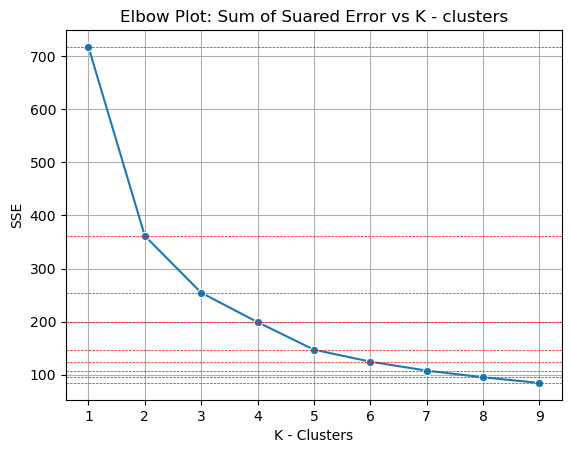

In [472]:
# plot elbow: sse vs k to see where optimal K is

plt.plot()
p1 = sns.lineplot(x = k_values, y = sse_values, marker = 'o')
for i in range(len(k_values)):
  p1.axhline(sse_values[i], linestyle = '--', linewidth = 0.5, color = 'red')

plt.ylabel('SSE')
plt.xlabel('K - Clusters')
plt.title('Elbow Plot: Sum of Suared Error vs K - clusters')
plt.grid(which = 'both')
plt.show()

In [473]:
# initialize K-Means model with optimal k
clustering_model = BisectingKMeans(
  n_clusters = 2, n_init = 10, random_state = random_state, 
  bisecting_strategy = 'biggest_inertia'
)

In [474]:
# fit model
temp = clustering_model.fit(X_train)

In [475]:
# get K-Means cluster centers
cluster_centers = clustering_model.cluster_centers_
cluster_centers

array([[ 1.42274646, -0.21809439],
       [-1.83975836,  0.28201861]])

In [476]:
# get predictions on test data
y_hat = clustering_model.predict(X_test)

In [477]:
# function for plotting segments
def jra_plot_segments(X, classifier_fit, cluster_centers, 
                      colors_contour, colors_scatter, color_centers,
                      title
  ):
  X_values = X
  X1_min = X_values[:,0].min() - 1
  X2_min = X_values[:,1].min() - 1
  X2_max = X_values[:,1].max() + 1
  X1_max = X_values[:,0].max() + 1
  X1_values = np.arange(X1_min, X1_max, 0.01)
  X2_values = np.arange(X2_min, X2_max, 0.01)

  X1, X2 = np.meshgrid(X1_values, X2_values)

  X_fill = np.array([X1.ravel(), X2.ravel()]).T

  # # plot labels
  y_hat = classifier_fit.predict(X)
  for i, j in enumerate(np.unique(y_hat)):
    plt.scatter(
      X_values[y_hat == j, 0], 
      X_values[y_hat == j, 1],
      color = colors_scatter[i],
      label = j
    )
    
  # plot centers
  for c in cluster_centers:
    plt.plot(c[0], c[1],
      color = color_centers, 
      marker = 'X',
      markersize = 10
    )
   
  
  y_hat_fill = classifier_fit.predict(X_fill).reshape(X1.shape)
  y_hat_fill
  # plot segemented regions
  plt.contourf(X1, X2, y_hat_fill.astype('float'), 
    alpha = 0.5,
    cmap = ListedColormap(colors_contour)  # https://matplotlib.org/stable/users/explain/colors/colormaps.html
  )
  
  # clean up plot
  plt.xlim(X1_min, X1_max)
  plt.ylim(X2_min, X2_max)
  plt.title(title)
  plt.xlabel('PC1')
  plt.ylabel('PC2')
  plt.legend()
  # plt.show()

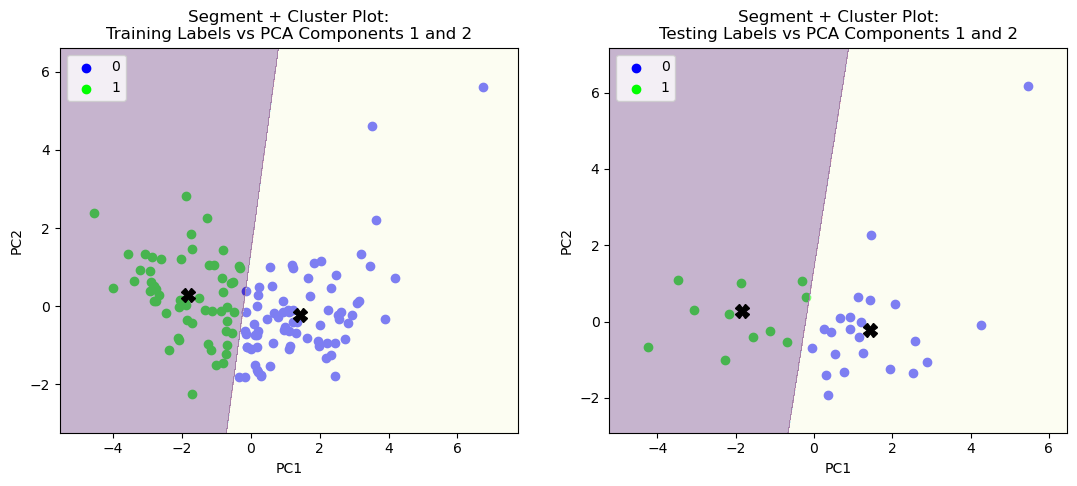

In [478]:
# plot segments for train + test dataset
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (13,5))
plt.subplot(121)
jra_plot_segments(
  X = X_train, 
  classifier_fit = clustering_model, 
  cluster_centers = cluster_centers,
  colors_contour = c6, colors_scatter = c7, color_centers = c5,
  title = 'Segment + Cluster Plot:\nTraining Labels vs PCA Components 1 and 2'
)
plt.subplot(122)
jra_plot_segments(
  X = X_test, 
  classifier_fit = clustering_model, 
  cluster_centers = cluster_centers,
  colors_contour = c6, colors_scatter = c7, color_centers = c5,
  title = 'Segment + Cluster Plot:\nTesting Labels vs PCA Components 1 and 2'
)

plt.show()

In [479]:
# function for plotting clusters
def jra_plot_clusters(X, k_values, bisecting_strategy = 'biggest_inertia',
                      title = 'Labels vs PCA Components 1 and 2'
  ):
  # set list of k values to explore
  for k in k_values:
    # plot subplots
    fig, axes = plt.subplots(1, 2, figsize = (18, 7))
    # title for sup-plot
    plt.suptitle("Evaluation Plots for k = $%d$" %k)
    # initialize clustering model
    clustering_model = BisectingKMeans(n_clusters = k, n_init = 10, 
      random_state = random_state, bisecting_strategy = 'biggest_inertia'
    )
    # fit model and predict labels
    y_hat = clustering_model.fit_predict(X)
    # get average silhouette score
    silhouette_avg = silhouette_score(X, labels = y_hat)
    # silhoutte score for each sample
    silhouette_values = silhouette_samples(X, labels = y_hat)
    # plot (left): silhoutte plot
    plt.subplot(121)
    
    # initialize plot parameters
    y_min = 0
    y_max = len(X)
    x_min = 0
    x_max = 1
    plt.xlim([x_min - 0.1, x_max])
    plt.ylim([y_min, y_max])
    
    for i in range(k):
      # aggregate silhoutte value for given cluster, c
      cluster_silhouette_values = silhouette_values[y_hat == i]
      # sort silhoutte values
      # cluster_silhouette_values.sort(reverse = True)
      cluster_silhouette_values.sort()
      # cluster size
      cluster_size = cluster_silhouette_values.shape[0]
      # define fill region for silhoutte
      silhoutte_fill = cm.nipy_spectral(float(i) / k)
      # set max y-value
      y_max = y_min + cluster_size
      # set y-values vector
      y_values = np.arange(y_min, y_max)
      # plot silhouttle
      plt.fill_betweenx(
        y_values,
        0,
        cluster_silhouette_values,
        facecolor = silhoutte_fill,
        edgecolor = silhoutte_fill,
        alpha = 0.7
      )
      # add cluster number
      plt.text(x = x_min, y = y_min + 0.5 * cluster_size, s = str(i + 1),
              fontsize = 12, fontweight = 'bold'
        )
      # update y_min values to separate silhouttes
      y_min = y_max
      # y_min = y_max + (0.05 * y_max)
    
    
    # clean up plot
    plt.axvline(x = silhouette_avg, color="red", linestyle="--")
    plt.text(x = silhouette_avg, y = 0.1*y_max, s = str(silhouette_avg.round(4)), 
            rotation = 0, fontsize = 12
            )
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.yticks([])
    plt.xlabel('Silhoutte Score')
    plt.ylabel('Cluster')
    plt.title('Silhoutte Plot:\n' + title)
    
    
    # plot (right): cluster plot
    plt.subplot(122)
    
    # initialize plot paramaters
    X1_values = X[:, 0]
    X2_values = X[:, 1]
    X1_min = X1_values.min() - 1
    X2_min = X2_values.min() - 1
    X1_max = X1_values.max() + 1
    X2_max = X2_values.max() + 1
    
    # generate point color map
    colors_point = cm.nipy_spectral(y_hat.astype(float) / k)
    
    # plot clusters
    plt.scatter(x = X1_values, y = X2_values, 
      color = colors_point, 
      edgecolor = "k",
      marker = ".", 
      s = 35, 
      alpha = 1,
      lw = 0
    )

    # clean up plot
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Cluster Plot:\n' + title)
    plt.xlim(X1_min, X1_max)
    plt.ylim(X2_min, X2_max)

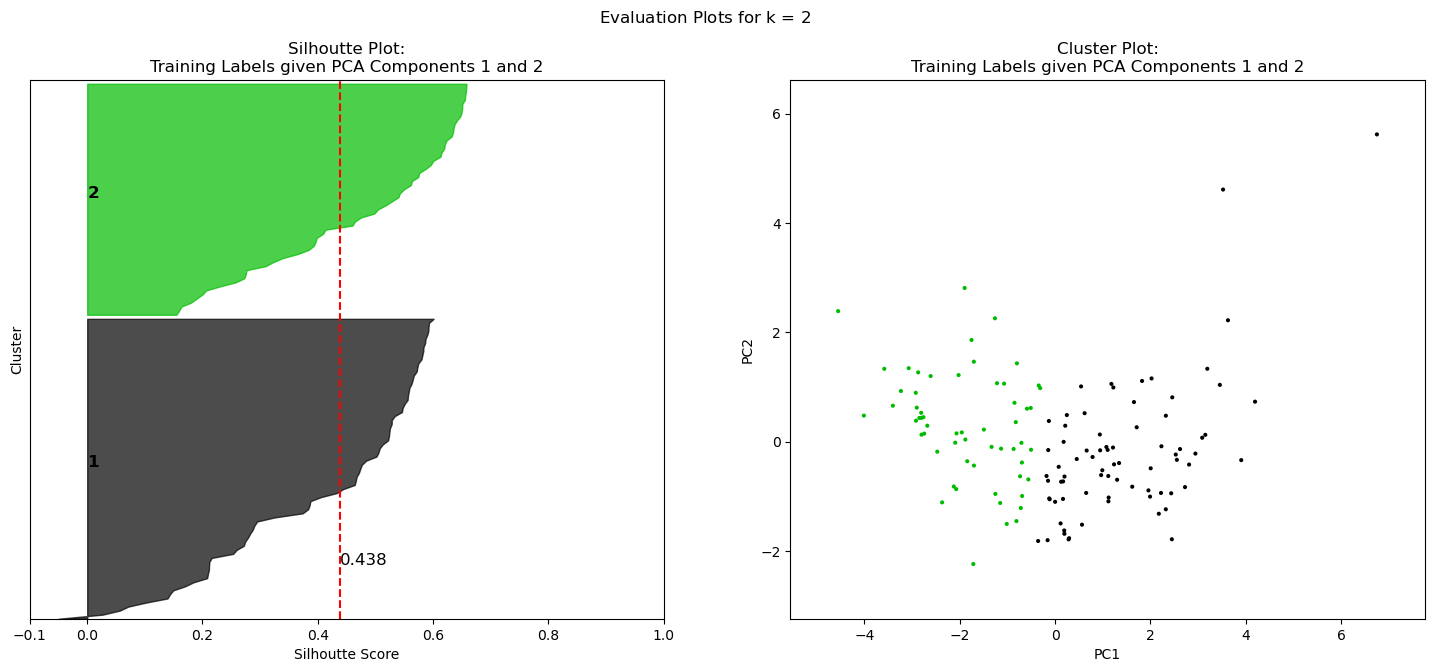

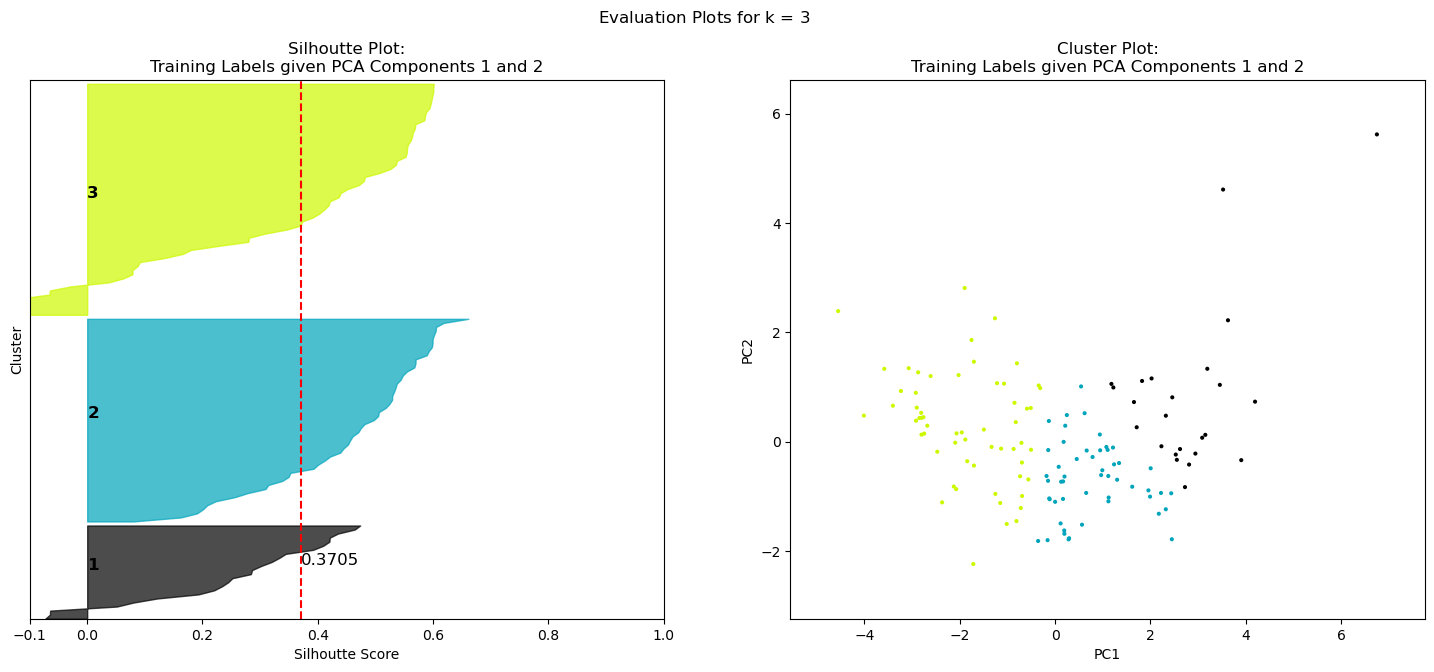

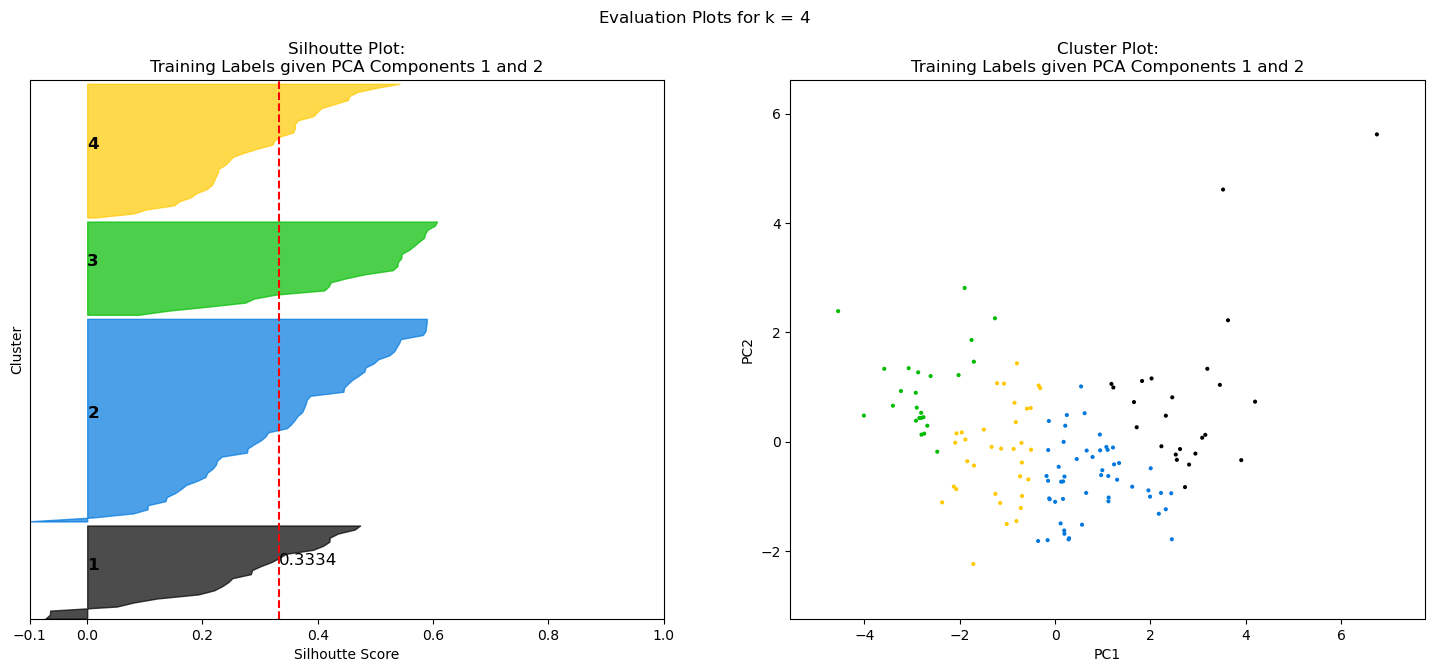

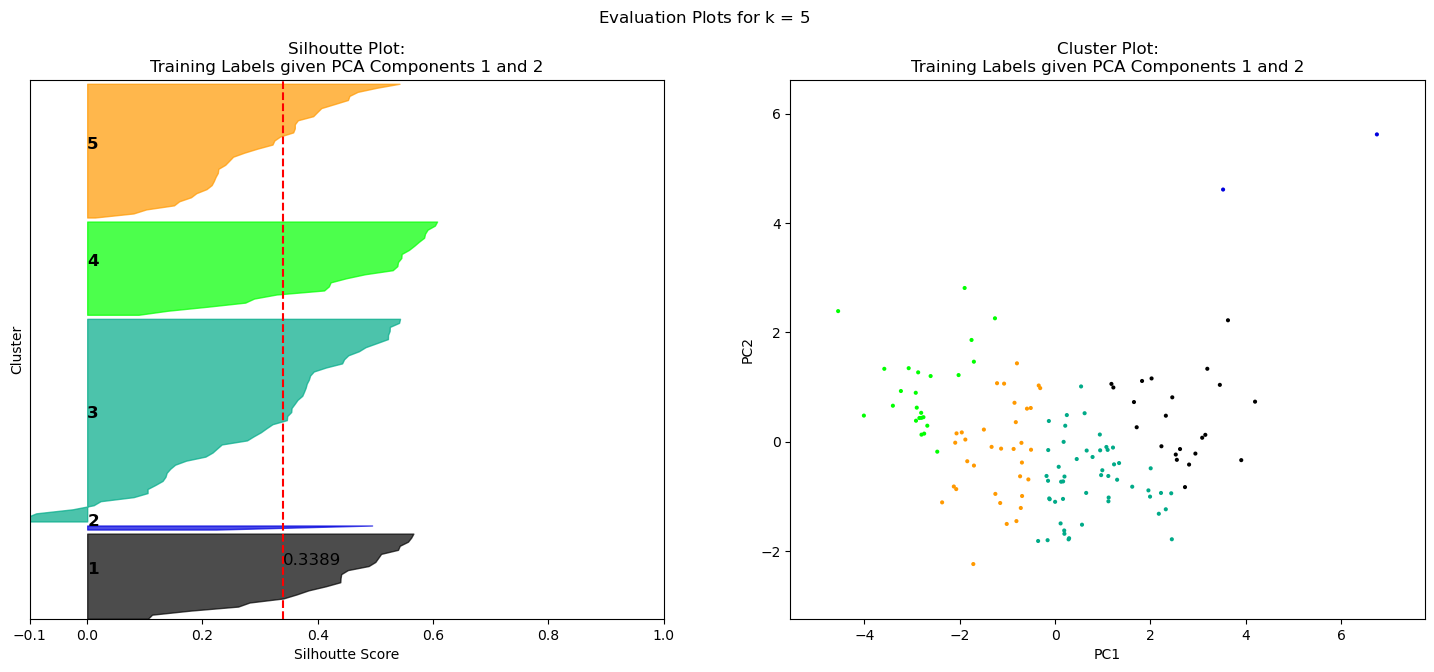

In [480]:
# explore various number of clusters, k on training data to select optimal
k_values = np.arange(2, 5 + 1, 1)
bisecting_strategy = 'biggest_inertia'
jra_plot_clusters(X = X_train, k_values = k_values, bisecting_strategy = 'biggest_inertia',
  title = 'Training Labels given PCA Components 1 and 2'
)

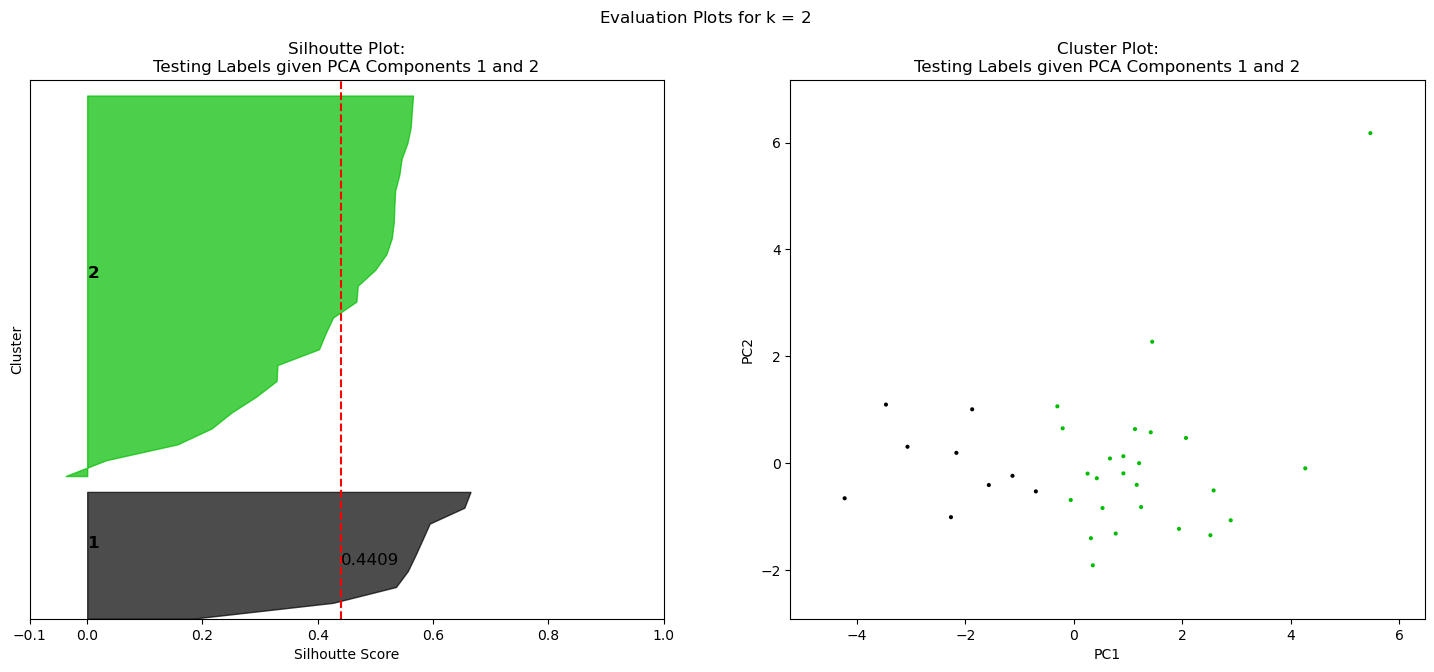

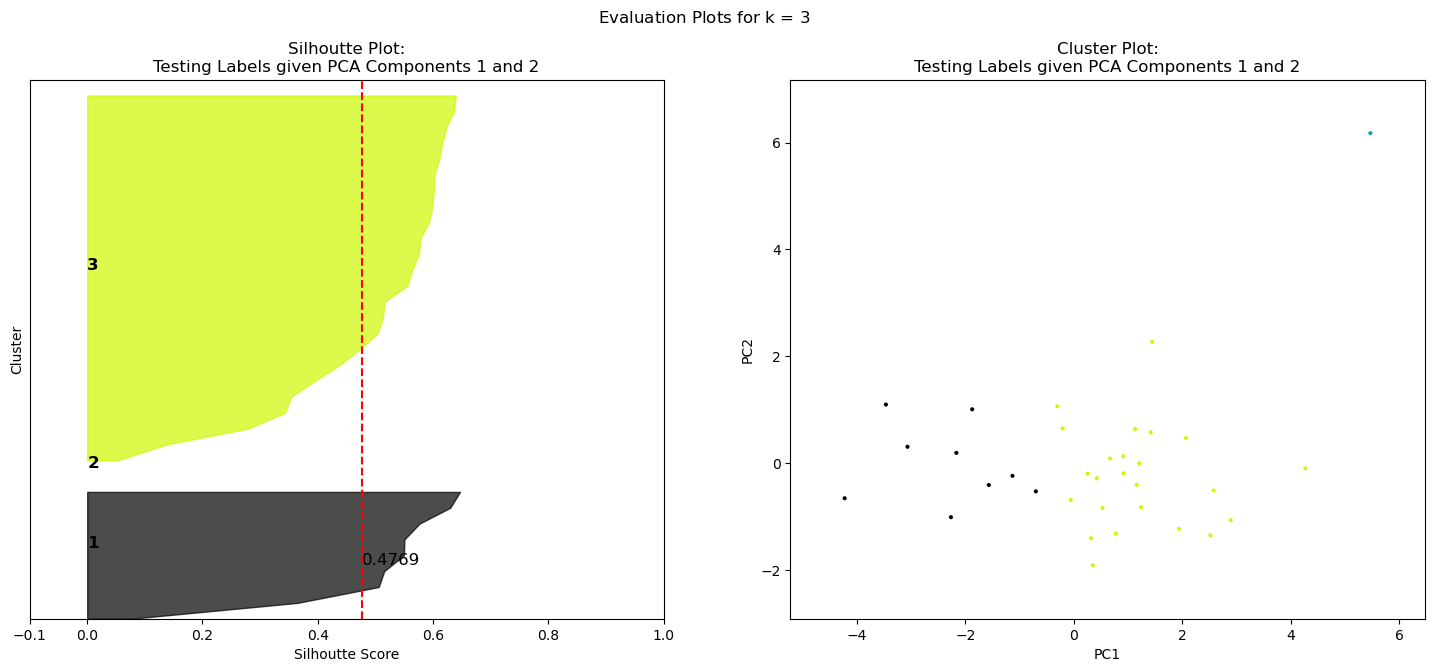

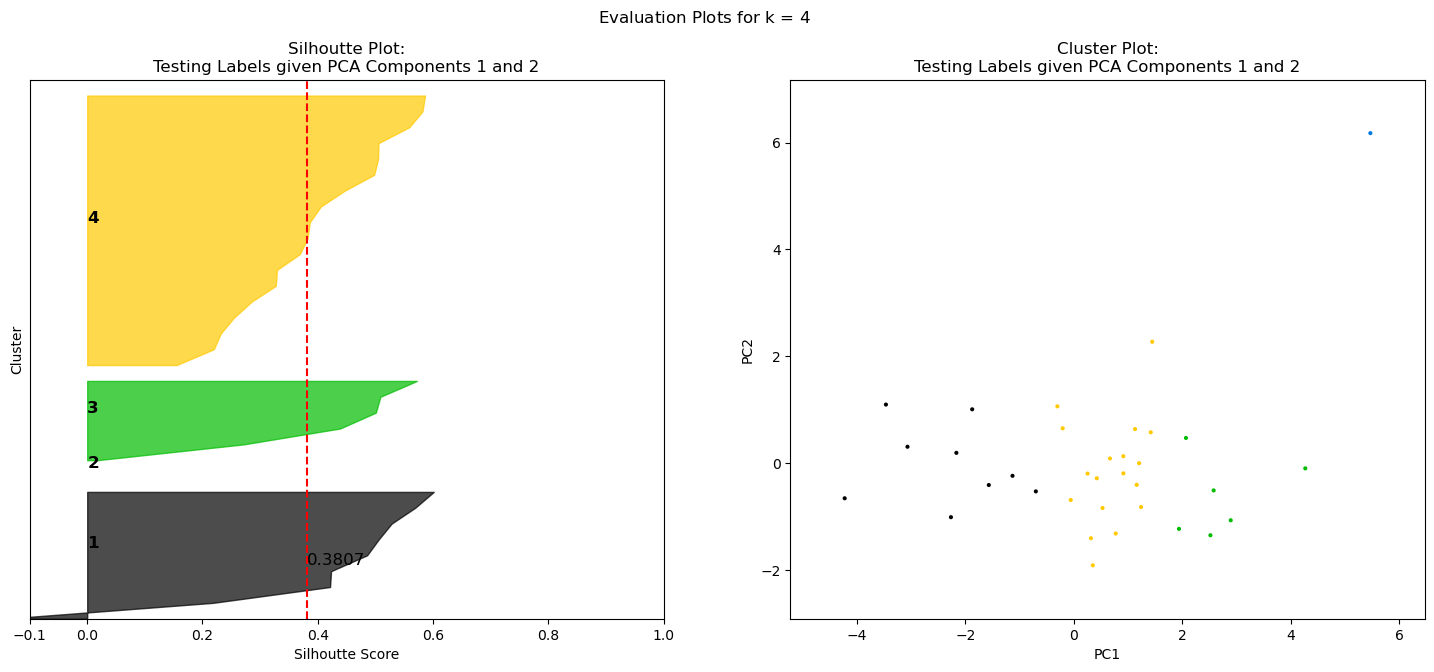

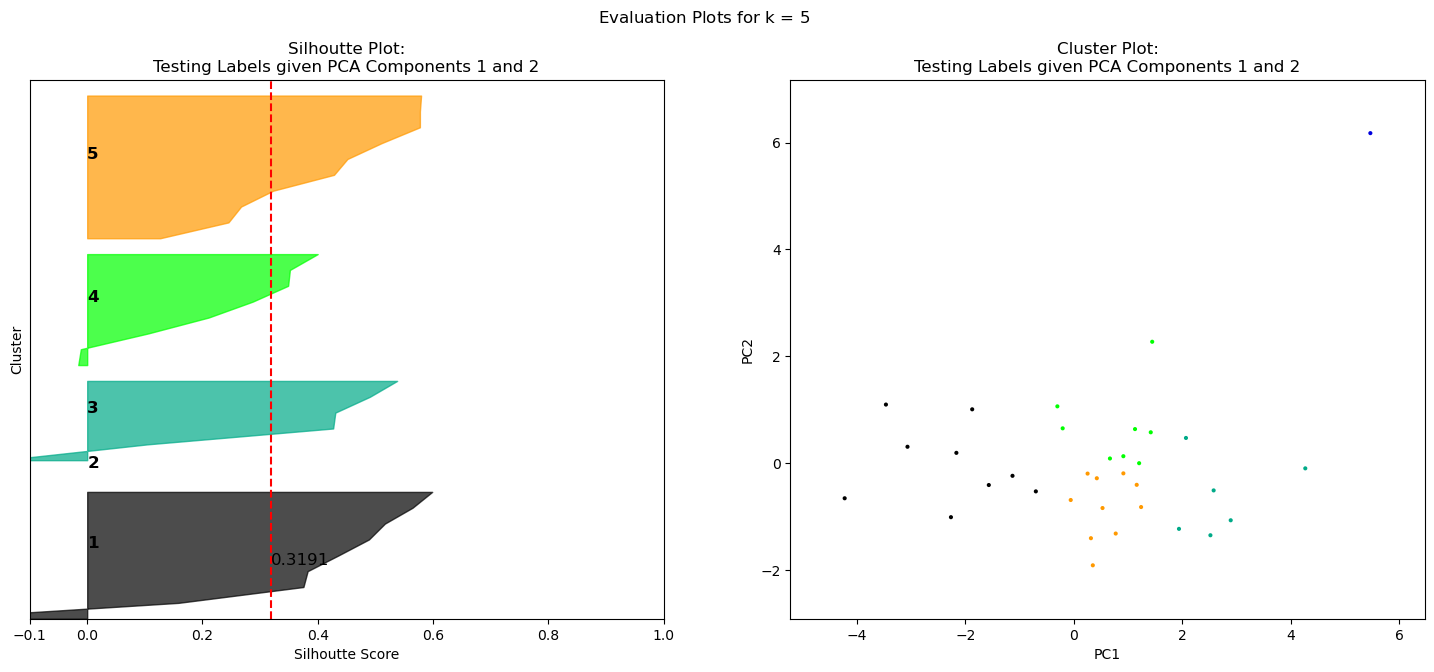

In [481]:
# explore various number of clusters, k on testing data to select optimal
k_values = np.arange(2, 5 + 1, 1)
bisecting_strategy = 'biggest_inertia'
jra_plot_clusters(X = X_test, k_values = k_values, bisecting_strategy = 'biggest_inertia',
  title = 'Testing Labels given PCA Components 1 and 2'
)

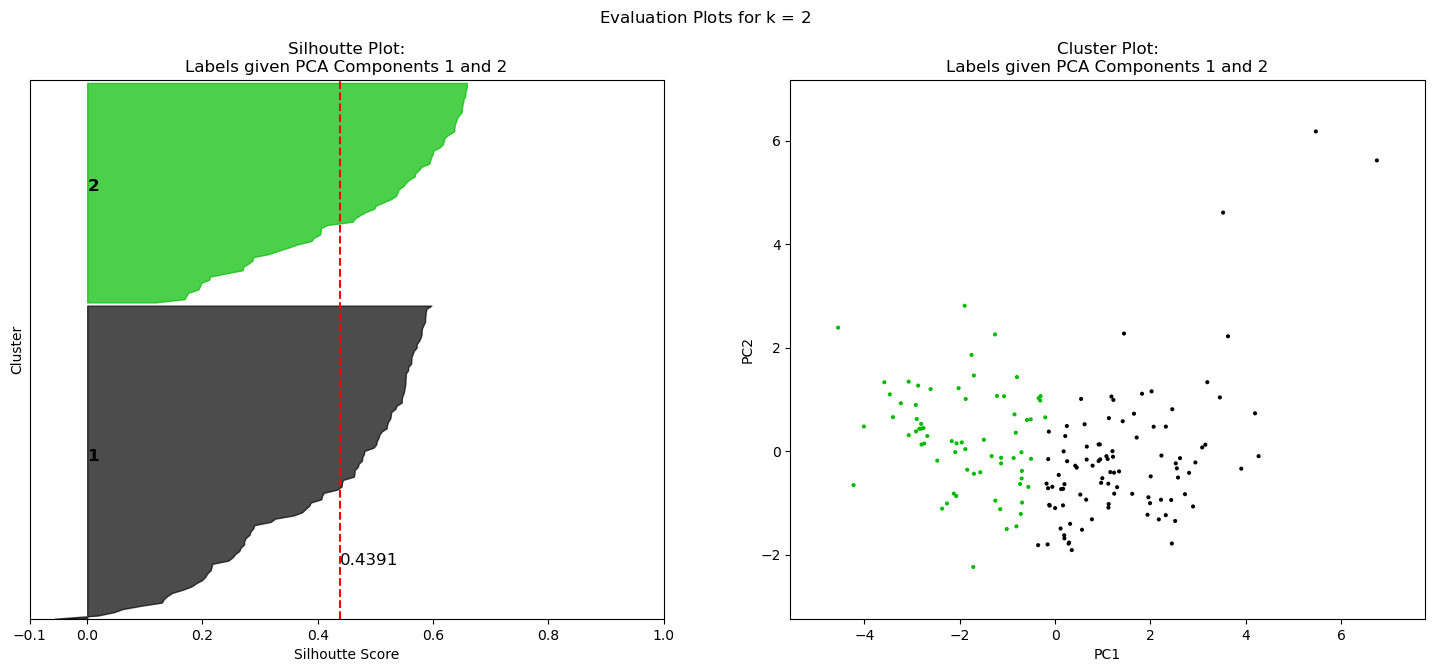

In [482]:
# selected cluster based on train-test evaluation 
k_values = [2]
bisecting_strategy = 'biggest_inertia'
jra_plot_clusters(X = X, k_values = k_values, bisecting_strategy = 'biggest_inertia',
  title = 'Labels given PCA Components 1 and 2'
)